In [10]:
pip install tensorflow==2.15

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [12]:
print(tf.__version__)

2.15.0


In [13]:
# Step 1: Generate data using the finite difference method
def generate_finite_difference_data(theta, u0, x_end, num_points):
    h = x_end / (num_points - 1)  # Calculate step size
    x = np.linspace(0, x_end, num_points).reshape(-1, 1)  # Create x values
    u = np.zeros((num_points, 1))  # Initialize u array
    u[0] = u0  # Set initial condition

    # Finite difference calculation
    for i in range(num_points - 1):
        u[i + 1] = u[i] + h * theta * u[i]

    return x, u

In [14]:
# Step 2: Define the PINN model for the IVP
class PINN(tf.keras.Model):
    def __init__(self, num_hidden_layers=6, neurons_per_layer=30, activation='tanh'):
        super(PINN, self).__init__()
        self.hidden_layers = []  # List to store hidden layers

        # Create hidden layers dynamically using a for-loop
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(
                tf.keras.layers.Dense(neurons_per_layer, activation=activation, kernel_initializer='glorot_normal')
            )

        # Output layer
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

        # Trainable parameter theta
        self.theta = tf.Variable(1., trainable=True, dtype='float32')
        self.theta_list = []  # Initial guess for theta

    # Forward pass through the neural network
    def call(self, x):
        # Pass input through each hidden layer in sequence
        for layer in self.hidden_layers:
            x = layer(x)

        # Pass through the output layer
        return self.output_layer(x)

In [15]:
# Step 3: Compute the residual of the ODE
def ode_residual(model, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        u = model(x)  # Neural network output u(x)
    u_x = tape.gradient(u, x)  # First derivative of u with respect to x

    # ODE residual: du/dx - theta * u = 0
    residual = u_x - model.theta * u
    return residual

In [16]:
def pinn_loss(model, x_interior, u_data, x_init, u_init, data_weight=1.0):
    """
    Define the loss function for the PINN, which combines the ODE residual, data loss, and initial condition.

    Args:
        model: The PINN model.
        x_interior: Interior points where we enforce the ODE.
        u_data: Data points from the FDM solution.
        x_init: The point where the initial condition is applied (e.g., x=0).
        u_init: The known value of u(x_init) (e.g., u(0) = u0).
        data_weight: Weighting factor for the data loss term.

    Returns:
        The total loss, including the ODE residual loss, data loss, and initial condition loss.
    """
    # ODE residual loss (du/dx - theta * u = 0)
    residual_loss = tf.reduce_mean(tf.square(ode_residual(model, x_interior)))

    # Data loss (from FDM)
    u_pred = model(x_interior)
    data_loss = tf.reduce_mean(tf.square(u_pred - u_data))

    # Initial condition loss: Enforce u(0) = u_init
    u_pred_init = model(x_init)  # Predict u(0) using the model
    init_loss = tf.reduce_mean(tf.square(u_pred_init - u_init))  # Initial condition loss

    # Total loss: Combine ODE residual, data loss, and initial condition loss
    total_loss = residual_loss + data_weight * data_loss + init_loss

    return total_loss



In [17]:
# Training step
def train_step(model, x_interior, u_data, x_init, u_init, optimizer, data_weight=1.0):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        loss = pinn_loss(model, x_interior, u_data, x_init, u_init, data_weight)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [22]:
# Convert data to TensorFlow tensors
true_theta = 0.5  # True parameter value for generating data
u0 = 1.0  # Initial condition
x_end = 1.0  # End of the domain
num_points = 100  # Number of points in the discretized domain


x_data, u_data = generate_finite_difference_data(true_theta, u0, x_end, num_points)
x_data_tf = tf.convert_to_tensor(x_data, dtype=tf.float32)
u_data_tf = tf.convert_to_tensor(u_data, dtype=tf.float32)
# Initial condition: u(0) = u0
x_init = tf.convert_to_tensor([[0.0]], dtype=tf.float32)  # Initial point (x=0)
u_init = tf.convert_to_tensor([[u0]], dtype=tf.float32)   # Known initial value u(0)=u0

# Initialize the PINN model
model = PINN(num_hidden_layers=5, neurons_per_layer=50, activation='tanh')
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Train the model
epochs = 2000
for epoch in range(epochs):
    loss = train_step(model, x_data_tf, u_data_tf, x_init, u_init, optimizer, data_weight=10.0)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}, Estimated theta: {model.theta.numpy()}')

# After training, print the estimated parameter
print(f"Estimated theta: {model.theta.numpy()}")

# Plot the learned solution u(x) vs FDM solution

u_pred = model(x_data_tf).numpy()

Epoch 0, Loss: 15.905747413635254, Estimated theta: 1.0009995698928833
Epoch 100, Loss: 0.27115917205810547, Estimated theta: 0.9041982293128967
Epoch 200, Loss: 0.16942352056503296, Estimated theta: 0.81184983253479
Epoch 300, Loss: 0.1066095381975174, Estimated theta: 0.7344704866409302
Epoch 400, Loss: 0.06622471660375595, Estimated theta: 0.6694793105125427
Epoch 500, Loss: 0.03992311283946037, Estimated theta: 0.6161503195762634
Epoch 600, Loss: 0.021866025403141975, Estimated theta: 0.5742207765579224
Epoch 700, Loss: 0.00816759280860424, Estimated theta: 0.5440018773078918
Epoch 800, Loss: 0.002941895043477416, Estimated theta: 0.5263811945915222
Epoch 900, Loss: 0.0003674051258713007, Estimated theta: 0.5175031423568726
Epoch 1000, Loss: 0.00024141545873135328, Estimated theta: 0.5125307440757751
Epoch 1100, Loss: 0.00019268454343546182, Estimated theta: 0.5088162422180176
Epoch 1200, Loss: 0.0001529710425529629, Estimated theta: 0.506213366985321
Epoch 1300, Loss: 0.0007982817

In [19]:
# Plot the learned solution u(x)
x_test = np.linspace(0, x_end, 100).reshape(-1, 1).astype(np.float32)
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
u_test = model(x_test_tf)

In [20]:
def analytical_sol(x):
  y = np.exp(true_theta *x)
  return y

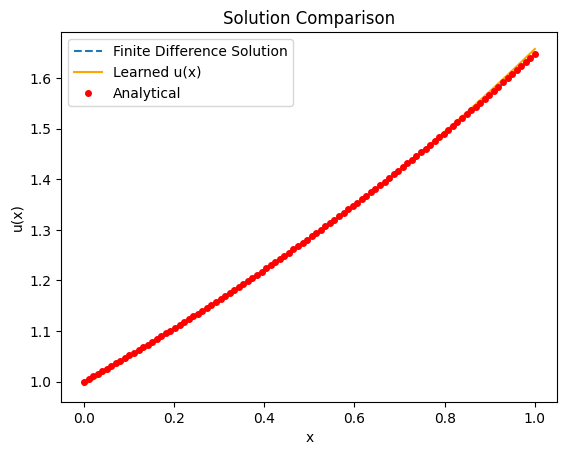

In [21]:
plt.plot(x_data, u_data, label='Finite Difference Solution', linestyle='--')
plt.plot(x_test, u_test, label='Learned u(x)', color='orange')
plt.plot(x_test, analytical_sol(x_test), marker='o', linestyle='', markersize=4, color='r', label='Analytical')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Solution Comparison')
plt.legend()
plt.show()